In [12]:
import os
from pathlib import Path

# Change to project root by walking up until a marker is found
markers = {'.git', 'pyproject.toml', 'requirements.txt', 'data'}
root = Path.cwd()
while root != root.parent and not any((root / m).exists() for m in markers):
    root = root.parent

os.chdir(root)

In [13]:

import pandas as pd
import numpy as np

In [14]:
colon_cancer_full = pd.read_csv("data/colon_cancer_full.csv")
display(colon_cancer_full.head())
colon_cancer_full.shape


,cases,py,year,registry_code,sex_label,country,continent,region,hdi,hdi_category,age_cont,age_group
0,0,60462.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,17.5,Young
1,0,72770.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,22.5,Young
2,0,64952.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,27.5,Young
3,1,45156.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,32.5,Young
4,0,28283.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,37.5,Young


(92326, 12)

In [15]:
from patsy import dmatrix

import statsmodels.api as sm

# Create spline basis for age_cont (cubic splines with 4 degrees of freedom)
# Note: dmatrix adds an 'Intercept' column by default
spline_basis = dmatrix("bs(age_cont, df=4, include_intercept=False)", data=colon_cancer_full, return_type='dataframe')

# Dummy encode sex_label and region, ensure all columns are float
X = pd.concat([
    spline_basis,
    pd.get_dummies(colon_cancer_full['sex_label'], drop_first=True),
    pd.get_dummies(colon_cancer_full['region'], drop_first=True)
], axis=1).astype(float)

# Remove the 'Intercept' column added by patsy (if present)
if 'Intercept' in X.columns:
    X = X.drop(columns=['Intercept'])

# Add intercept using statsmodels (this creates a 'const' column)
X = sm.add_constant(X, has_constant='add')

# Response variable: cases
y = colon_cancer_full['cases']

# Offset: log(py)
offset = np.log(colon_cancer_full['py'])

# Fit Poisson regression
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
poisson_results = poisson_model.fit()

print(poisson_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                92326
Model:                            GLM   Df Residuals:                    92309
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7782e+05
Date:                Fri, 31 Oct 2025   Deviance:                   3.0963e+05
Time:                        00:18:58   Pearson chi2:                 3.12e+05
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [16]:
# Predict expected counts
colon_cancer_full['predicted_counts'] = poisson_results.predict(X, offset=offset)
display(colon_cancer_full.head())

# Save the updated DataFrame with predictions to CSV
colon_cancer_full.to_csv('data/colon_cancer_full_with_predictions.csv', index=False)
print("colon_cancer_full with predictions saved to data/colon_cancer_full_with_predictions.csv")

# --- Poisson Regression Analysis ---


,cases,py,year,registry_code,sex_label,country,continent,region,hdi,hdi_category,age_cont,age_group,predicted_counts
0,0,60462.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,17.5,Young,0.012237
1,0,72770.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,22.5,Young,0.038171
2,0,64952.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,27.5,Young,0.081009
3,1,45156.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,32.5,Young,0.123121
4,0,28283.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,37.5,Young,0.155336


colon_cancer_full with predictions saved to data/colon_cancer_full_with_predictions.csv


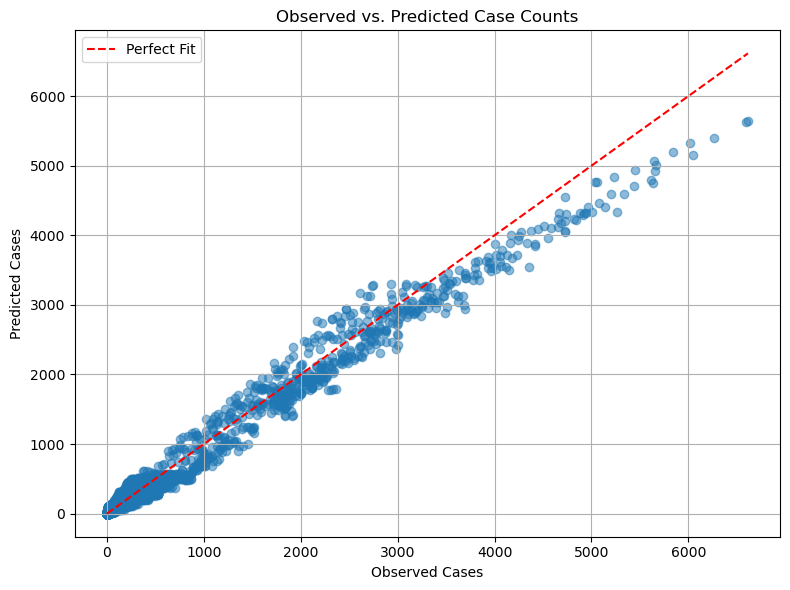

In [17]:
# Visualize observed vs. predicted counts

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(colon_cancer_full['cases'], colon_cancer_full['predicted_counts'], alpha=0.5)
plt.plot([colon_cancer_full['cases'].min(), colon_cancer_full['cases'].max()],
         [colon_cancer_full['cases'].min(), colon_cancer_full['cases'].max()],
         'r--', label='Perfect Fit')
plt.xlabel('Observed Cases')
plt.ylabel('Predicted Cases')
plt.title('Observed vs. Predicted Case Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

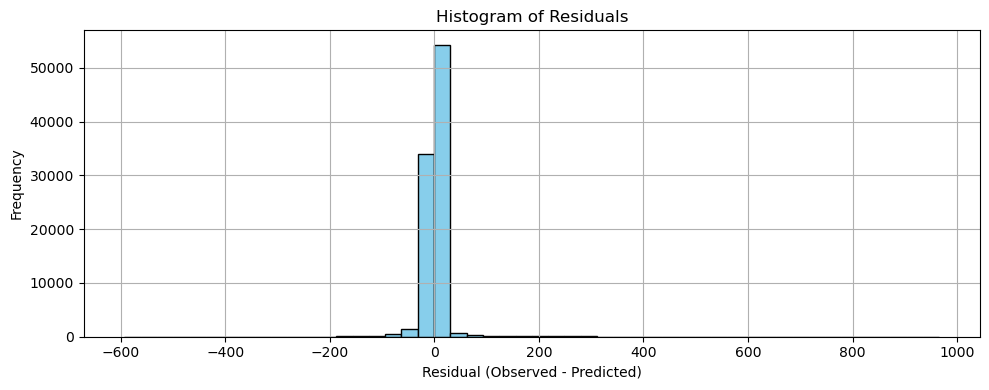

In [18]:
# Plot residuals
colon_cancer_full['residuals'] = colon_cancer_full['cases'] - colon_cancer_full['predicted_counts']

plt.figure(figsize=(10, 4))
plt.hist(colon_cancer_full['residuals'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual (Observed - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

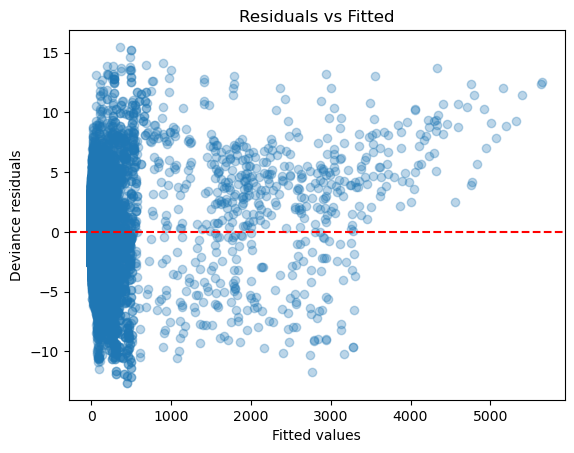

In [19]:
# Residuals vs Fitted plot

fitted = poisson_results.fittedvalues
residuals = poisson_results.resid_deviance

plt.scatter(fitted, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Deviance residuals")
plt.title("Residuals vs Fitted")
plt.show()


In [20]:
# Test for overdispersion
mean_counts = colon_cancer_full['predicted_counts'].mean()
var_counts = colon_cancer_full['predicted_counts'].var()
overdispersion_ratio = var_counts / mean_counts
print(f"Mean of predicted counts: {mean_counts:.2f}")
print(f"Variance of predicted counts: {var_counts:.2f}")
print(f"Overdispersion ratio (Variance/Mean): {overdispersion_ratio:.2f}\n")

deviance = poisson_results.deviance
df_resid = poisson_results.df_resid
dispersion = deviance / df_resid
print("Dispersion:", dispersion)
if dispersion > 1.5:
    print("Evidence of overdispersion detected.")

Mean of predicted counts: 33.42
Variance of predicted counts: 42309.48
Overdispersion ratio (Variance/Mean): 1265.99

Dispersion: 3.3543179571787443
Evidence of overdispersion detected.


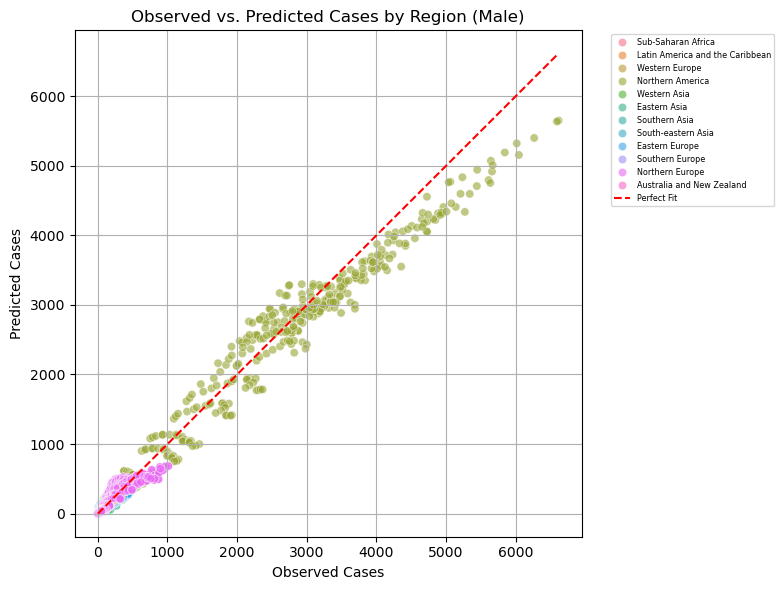

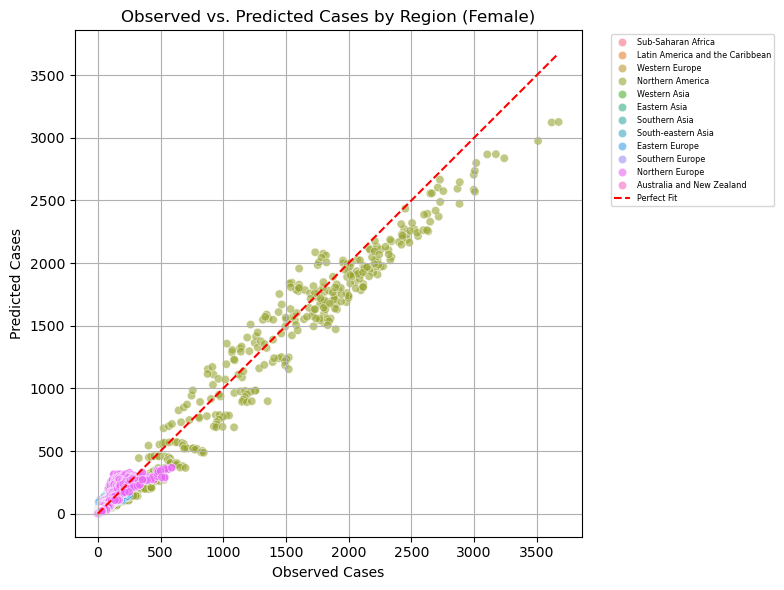

In [21]:
# Stratified scatter plots: Observed vs. Predicted by sex_label, colored by region

import matplotlib.pyplot as plt
import seaborn as sns

for sex in colon_cancer_full['sex_label'].unique():
    plt.figure(figsize=(8, 6))
    subset = colon_cancer_full[colon_cancer_full['sex_label'] == sex]
    sns.scatterplot(
        data=subset,
        x='cases',
        y='predicted_counts',
        hue='region',
        alpha=0.6
    )
    plt.plot([subset['cases'].min(), subset['cases'].max()],
             [subset['cases'].min(), subset['cases'].max()],
             'r--', label='Perfect Fit')
    plt.xlabel('Observed Cases')
    plt.ylabel('Predicted Cases')
    plt.title(f'Observed vs. Predicted Cases by Region ({sex})')
    plt.legend(fontsize='xx-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

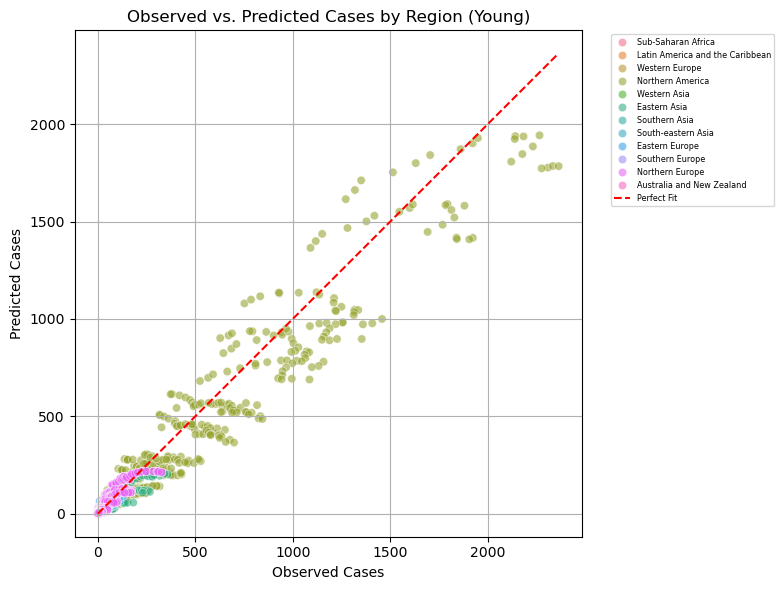

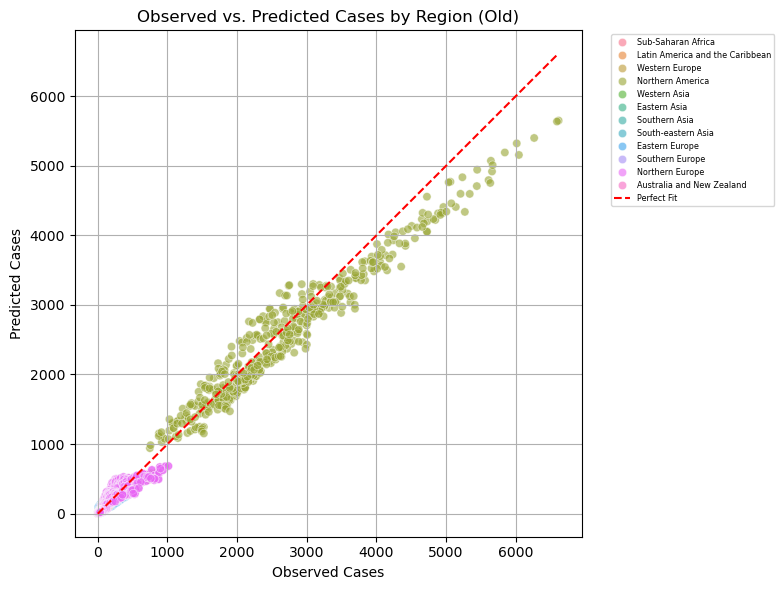

In [22]:
# Stratified scatter plots: Observed vs. Predicted by age_group, colored by region

for age_group in colon_cancer_full['age_group'].unique():
    plt.figure(figsize=(8, 6))
    subset = colon_cancer_full[colon_cancer_full['age_group'] == age_group]
    sns.scatterplot(
        data=subset,
        x='cases',
        y='predicted_counts',
        hue='region',
        alpha=0.6
    )
    plt.plot([subset['cases'].min(), subset['cases'].max()],
             [subset['cases'].min(), subset['cases'].max()],
             'r--', label='Perfect Fit')
    plt.xlabel('Observed Cases')
    plt.ylabel('Predicted Cases')
    plt.title(f'Observed vs. Predicted Cases by Region ({age_group})')
    plt.legend(fontsize='xx-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

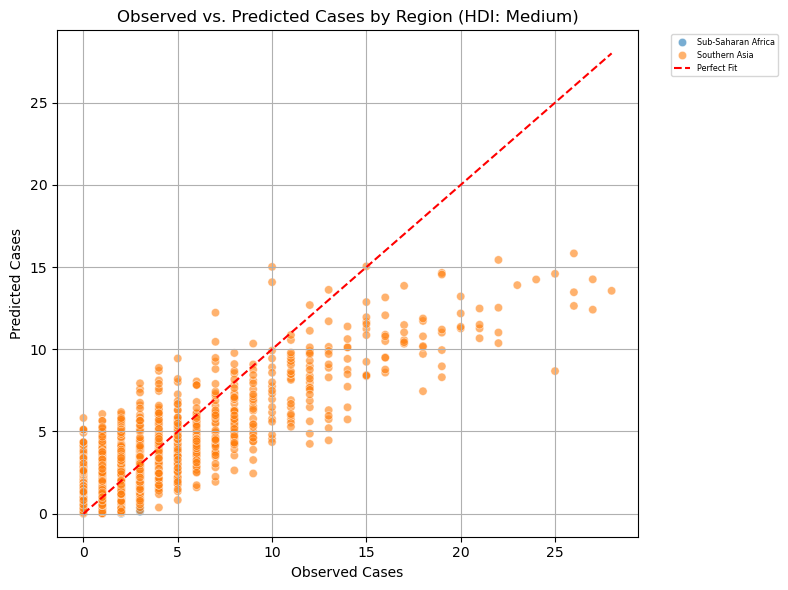

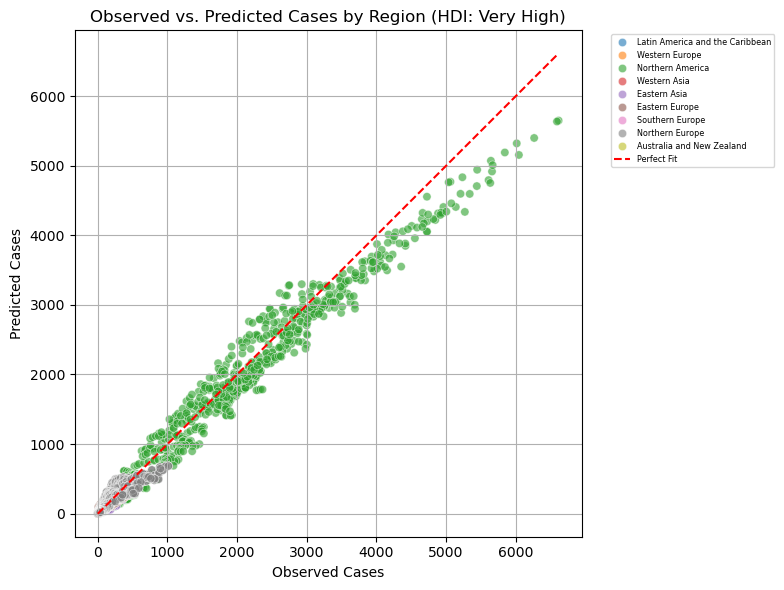

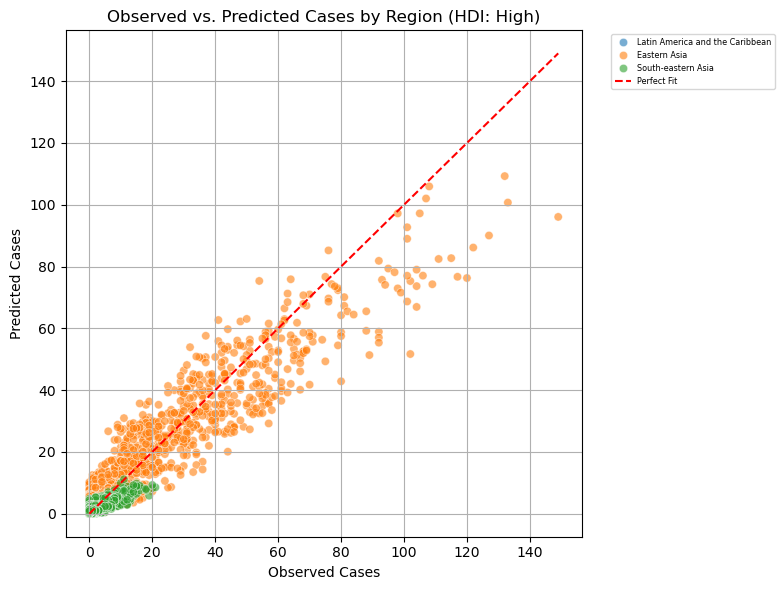

In [23]:

# Stratified scatter plots: Observed vs. Predicted by hdi_category, colored by region
for hdi_cat in colon_cancer_full['hdi_category'].dropna().unique():
    plt.figure(figsize=(8, 6))
    subset = colon_cancer_full[colon_cancer_full['hdi_category'] == hdi_cat]
    sns.scatterplot(
        data=subset,
        x='cases',
        y='predicted_counts',
        hue='region',
        alpha=0.6
    )
    plt.plot([subset['cases'].min(), subset['cases'].max()],
             [subset['cases'].min(), subset['cases'].max()],
             'r--', label='Perfect Fit')
    plt.xlabel('Observed Cases')
    plt.ylabel('Predicted Cases')
    plt.title(f'Observed vs. Predicted Cases by Region (HDI: {hdi_cat})')
    plt.legend(fontsize='xx-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Poisson Model summary review:


**Age (Spline Terms)**
- The coefficients for ``bs(age_cont, df=4, include_intercept=False)[0-3]`` represent the effect of age on colon cancer incidence, modeled flexibly using cubic splines.
- All spline coefficients are large, positive, and highly significant (p < 0.001), indicating a strong, non-linear relationship between age and incidence. As age increases, the risk of colon cancer rises sharply, but the exact shape is best visualized as a curve rather than interpreted term-by-term.

**Sex**
- **Male:**
    - Coefficient: **0.7070** (p < 0.001)
    - Interpretation: Males have a higher incidence rate than females.
    - The incidence rate ratio (IRR) is exp(0.7070) ≈ 2.03, meaning males have about twice the incidence rate of females, holding other variables constant.

**Region**
- Each region’s coefficient is compared to the reference region - Australia and New Zealand.
- **Positive coefficients** (e.g., Eastern Europe: **0.4497**, Northern America: 0.2708) mean higher incidence rates than Australia and New Zealand.
- **Negative coefficients** (e.g., Eastern Asia: **-0.4254**, Sub-Saharan Africa: **-2.0515**) mean lower incidence rates than Australia and New Zealand.
- For example:
    - **Eastern Europe**: `exp(0.4497) ≈ 1.57` → 57% higher incidence than Australia and New Zealand
    - **Eastern Asia:** `exp(-0.4254) ≈ 0.65` → 35% lower incidence than Australia and New Zealand
    **Sub-Saharan Africa:** `exp(-2.0515) ≈ 0.13` → 87% lower incidence than Australia and New Zealand

**Statistical Significance**
- All coefficients shown are highly statistically significant (p < 0.001), indicating strong evidence that age, sex, and region are important predictors of colon cancer incidence.

**Summary**
- **Age:** Strong, non-linear increase in risk with age.
- **Sex:** Males have about double the incidence rate of females.
- **Region:** Large differences by region, with some regions (e.g., Eastern Europe, Northern America) having much higher rates, and others (e.g., Sub-Saharan Africa, Eastern Asia) much lower, compared to Australia and New Zealand.



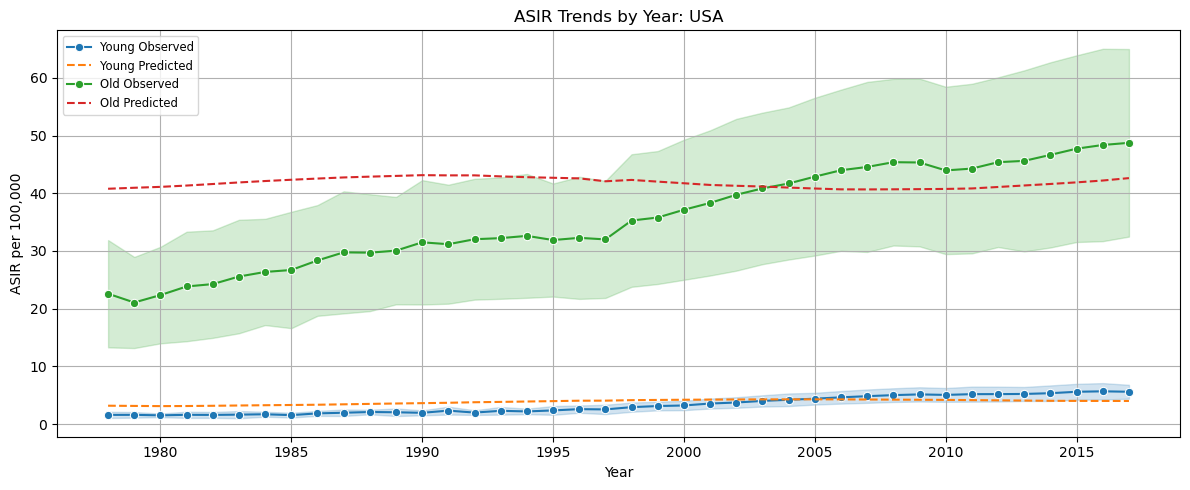

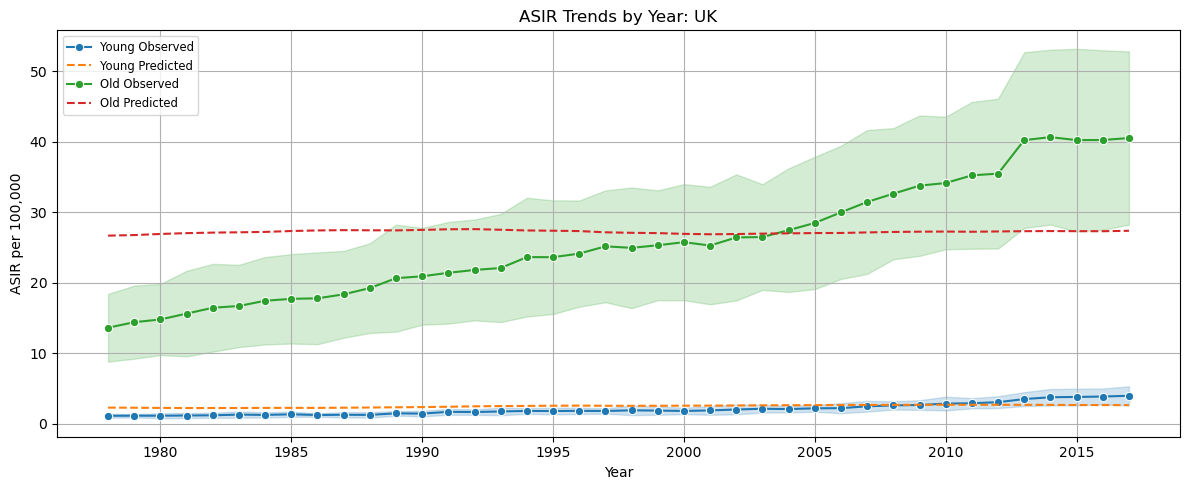

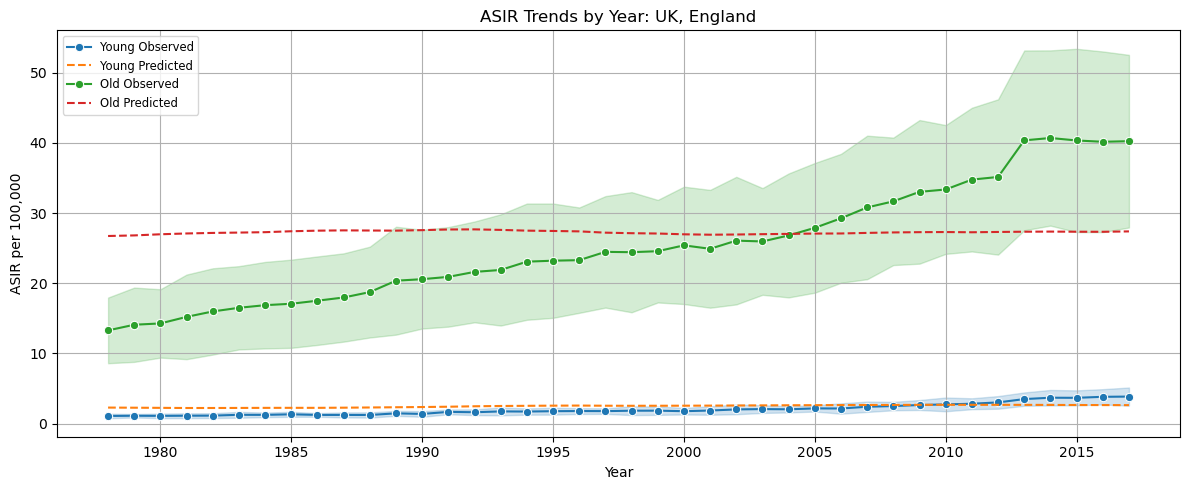

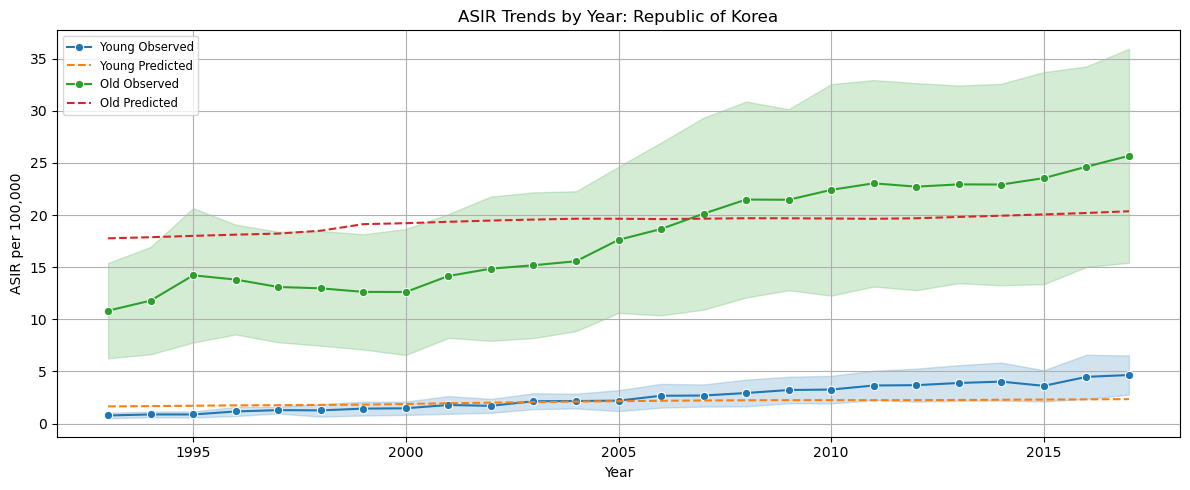

In [25]:
# ASIR Trends by Year for Top 4 Countries

country_aggregated_df2 = pd.read_csv("data/country_aggregated_df2.csv")

# Select top 4 countries by total cases to plot
top_countries = country_aggregated_df2.groupby('country')['cases'].sum().nlargest(4).index.tolist()

for country in top_countries:
    plt.figure(figsize=(12, 5))
    for age_group in ['Young', 'Old']:
        df = country_aggregated_df2[(country_aggregated_df2['country'] == country) & (country_aggregated_df2['age_group'] == age_group)]
        sns.lineplot(data=df, x='year', y='ASIR', marker='o', label=f"{age_group} Observed")
        
        # Predicted: sum predicted_counts and py for each year, then calculate predicted ASIR
        pred_df = colon_cancer_full[
            (colon_cancer_full['country'] == country) &
            (colon_cancer_full['age_group'] == age_group)
        ].groupby('year').agg({'predicted_counts': 'sum', 'py': 'sum'}).reset_index()
        pred_df['pred_ASIR'] = pred_df['predicted_counts'] / pred_df['py'] * 100000
        sns.lineplot(data=pred_df, x='year', y='pred_ASIR', linestyle='--', label=f"{age_group} Predicted")
        
    plt.title(f"ASIR Trends by Year: {country}")
    plt.xlabel("Year")
    plt.ylabel("ASIR per 100,000")
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


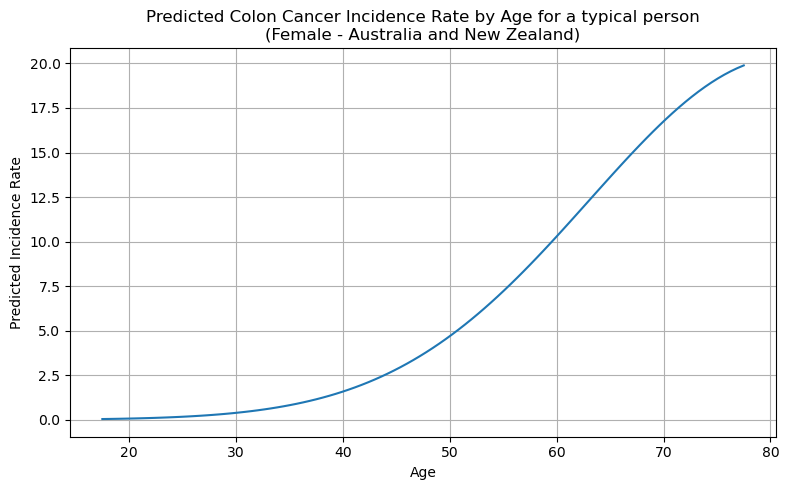

In [28]:
# Predicted Incidence Rate by Age
# Generate a range of ages
age_grid = np.linspace(colon_cancer_full['age_cont'].min(), colon_cancer_full['age_cont'].max(), 100)
spline_basis_grid = dmatrix("bs(age_cont, df=4, include_intercept=False)", 
                            {"age_cont": age_grid}, return_type='dataframe')

# Build the design matrix for prediction
# Start with all zeros for all columns in X
X_pred = pd.DataFrame(0, index=np.arange(len(age_grid)), columns=X.columns)

# Set intercept to 1 (statsmodels uses 'const' as the column name)
X_pred['const'] = 1.0

# Fill spline columns (exclude the Patsy 'Intercept', model already has 'const')
spline_cols = [c for c in spline_basis_grid.columns if c != 'Intercept']
for col in spline_cols:
    X_pred[col] = spline_basis_grid[col].values

# Set reference sex (Female: 0, Male: 1)
if 'Male' in X_pred.columns:
    X_pred['Male'] = 0.0  # Reference: Female

# Set all region dummies to 0 (reference region)
for col in X_pred.columns:
    if col not in ['const'] + spline_cols + ['Male']:
        X_pred[col] = 0.0

# Ensure columns match the training design matrix exactly (drop any extras, keep order)
X_pred = X_pred.reindex(columns=X.columns)

# Calculate mean log(py) for offset (representing a typical exposure)
mean_log_py = np.log(colon_cancer_full['py']).replace([-np.inf, np.inf], np.nan).dropna().mean()

# Predict (use mean log(py) as offset for visualization)
predicted_rate = poisson_results.predict(X_pred, offset=mean_log_py)

plt.figure(figsize=(8, 5))
plt.plot(age_grid, predicted_rate)
plt.xlabel('Age')
plt.ylabel('Predicted Incidence Rate')
plt.title('Predicted Colon Cancer Incidence Rate by Age for a typical person\n(Female - Australia and New Zealand)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
region_cols = [
    'Eastern Asia', 'Eastern Europe', 'Latin America and the Caribbean',
    'Northern America', 'Northern Europe', 'South-eastern Asia',
    'Southern Asia', 'Southern Europe', 'Sub-Saharan Africa',
    'Western Asia', 'Western Europe'
]
region_coefs = poisson_results.params[region_cols]
region_irrs = np.exp(region_coefs)

print("Incidence Rate Ratios (IRRs) for Regions vs. Reference:")
print(region_irrs)

Incidence Rate Ratios (IRRs) for Regions vs. Reference:
Eastern Asia                       0.653510
Eastern Europe                     1.567798
Latin America and the Caribbean    0.497602
Northern America                   1.311019
Northern Europe                    0.817611
South-eastern Asia                 0.236643
Southern Asia                      0.148588
Southern Europe                    0.897092
Sub-Saharan Africa                 0.128548
Western Asia                       0.841991
Western Europe                     1.025001
dtype: float64


In [30]:
# Negative Binomial GLM (NB2) fit with exposure offset
from statsmodels.discrete.discrete_model import NegativeBinomial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure X, y, offset, and colon_cancer_full exist from prior cells
assert 'X' in globals() and 'y' in globals() and 'offset' in globals(), "Run the earlier cells to build X, y, and offset first."

# Fit NB2 model (log link), using the log(py) offset already computed
nb_model = NegativeBinomial(endog=y, exog=X, offset=offset)
nb_res = nb_model.fit(method='lbfgs', maxiter=200, disp=False)
print(nb_res.summary())

                     NegativeBinomial Regression Results                      
Dep. Variable:                  cases   No. Observations:                92326
Model:               NegativeBinomial   Df Residuals:                    92309
Method:                           MLE   Df Model:                           16
Date:                Fri, 31 Oct 2025   Pseudo R-squ.:                  0.2891
Time:                        00:32:59   Log-Likelihood:            -1.9880e+05
converged:                       True   LL-Null:                   -2.7965e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                            -13.8404      0.020   -676.831      0.000     -13.881     -13.800
bs(age_cont, df=4, incl

Saved NB predictions to data/colon_cancer_full_with_nb_preds.csv


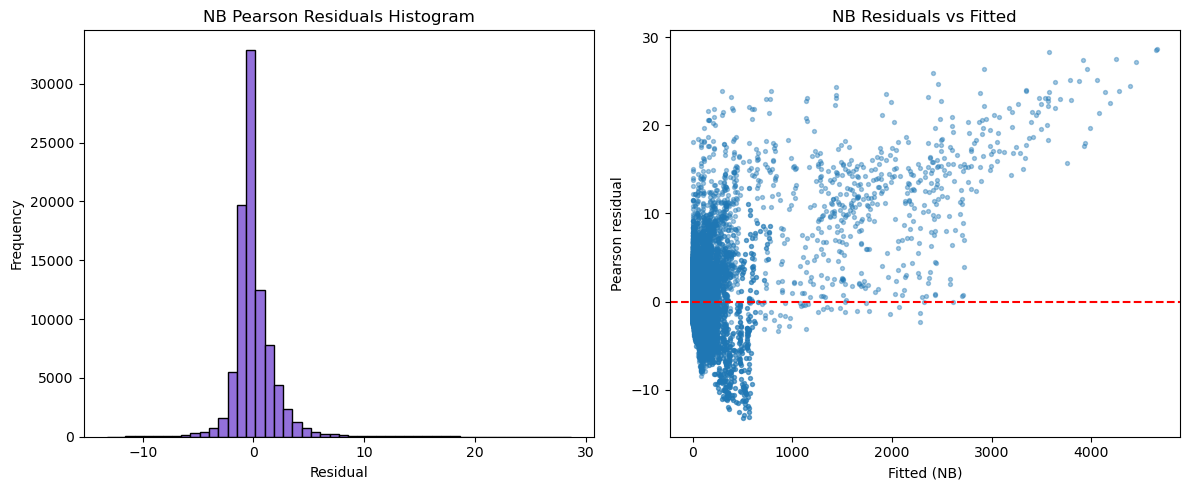

In [31]:
# Predictions, residuals, and export for Negative Binomial
colon_cancer_full['nb_predicted_counts'] = nb_res.predict(X, offset=offset)

# Save with NB predictions for downstream use
out_path = Path('data') / 'colon_cancer_full_with_nb_preds.csv'
colon_cancer_full.to_csv(out_path, index=False)
print(f"Saved NB predictions to {out_path}")

# Residual diagnostics
pearson_resid = (y - colon_cancer_full['nb_predicted_counts']) / np.sqrt(colon_cancer_full['nb_predicted_counts'].clip(lower=1e-9))
fitted_nb = colon_cancer_full['nb_predicted_counts']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(pearson_resid, bins=50, color='mediumpurple', edgecolor='black')
axes[0].set_title('NB Pearson Residuals Histogram')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')

axes[1].scatter(fitted_nb, pearson_resid, s=8, alpha=0.4)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Fitted (NB)')
axes[1].set_ylabel('Pearson residual')
axes[1].set_title('NB Residuals vs Fitted')
plt.tight_layout()
plt.show()

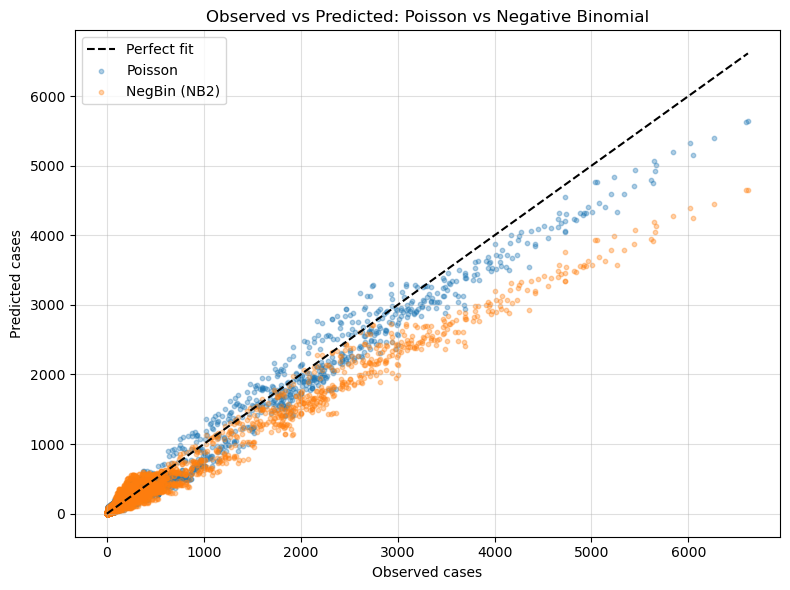

In [32]:
# Observed vs Predicted comparison (Poisson vs NB)
plt.figure(figsize=(8, 6))
lims = [0, max(colon_cancer_full['cases'].max(),
                colon_cancer_full['predicted_counts'].max(),
                colon_cancer_full['nb_predicted_counts'].max())]
plt.plot(lims, lims, 'k--', label='Perfect fit')
plt.scatter(colon_cancer_full['cases'], colon_cancer_full['predicted_counts'],
            s=10, alpha=0.35, label='Poisson')
plt.scatter(colon_cancer_full['cases'], colon_cancer_full['nb_predicted_counts'],
            s=10, alpha=0.35, label='NegBin (NB2)')
plt.xlabel('Observed cases')
plt.ylabel('Predicted cases')
plt.title('Observed vs Predicted: Poisson vs Negative Binomial')
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

In [33]:
# Metrics: dispersion and information criteria
# Poisson dispersion (deviance/df_resid)
poisson_dispersion = float(poisson_results.deviance / poisson_results.df_resid)
# NB dispersion via Pearson chi2 / df_resid (fallback manual if attr missing)
try:
    nb_pearson_chi2 = float(nb_res.pearson_chi2)
except Exception:
    mu_hat = nb_res.predict(X, offset=offset)
    # alpha is the last parameter in many NB2 specs; try to fetch by name or position
    alpha_est = float(nb_res.params.get('alpha', nb_res.params.iloc[-1]))
    nb_pearson_chi2 = float(np.sum(((y - mu_hat)**2) / (mu_hat + alpha_est * mu_hat**2)))
nb_df_resid = int(nb_res.df_resid) if hasattr(nb_res, 'df_resid') else (len(y) - len(nb_res.params))
nb_dispersion = nb_pearson_chi2 / nb_df_resid

metrics = {
    'Poisson': {'AIC': float(poisson_results.aic), 'BIC': float(poisson_results.bic), 'Dispersion': poisson_dispersion},
    'NegBin': {'AIC': float(nb_res.aic), 'BIC': float(nb_res.bic), 'Dispersion': float(nb_dispersion)}
}
import pprint; pprint.pprint(metrics)

{'NegBin': {'AIC': 397632.7702759518,
            'BIC': 397802.5657352292,
            'Dispersion': 1.0712320474843902},
 'Poisson': {'AIC': 555681.2127218061,
             'BIC': -745742.5442704558,
             'Dispersion': 3.3543179571787443}}


/rds/general/user/oohia/home/.conda/envs/colon-cancer-data/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [34]:
# IRRs (Incidence Rate Ratios) and 95% CIs from NB model
params = nb_res.params.copy()
ci = nb_res.conf_int()
irr = np.exp(params)
irr_ci = np.exp(ci)

# Region IRRs (same columns as earlier region dummies if present)
region_cols = [
    'Eastern Asia', 'Eastern Europe', 'Latin America and the Caribbean',
    'Northern America', 'Northern Europe', 'South-eastern Asia',
    'Southern Asia', 'Southern Europe', 'Sub-Saharan Africa',
    'Western Asia', 'Western Europe'
 ]
existing_region_cols = [c for c in region_cols if c in params.index]
irr_df = pd.DataFrame({
    'IRR': irr[existing_region_cols],
    'CI_lower': irr_ci.loc[existing_region_cols, 0],
    'CI_upper': irr_ci.loc[existing_region_cols, 1],
}).sort_values('IRR', ascending=False)
display(irr_df)

# Male IRR if column exists
if 'Male' in params.index:
    male_irr = float(irr['Male']); male_lo = float(irr_ci.loc['Male', 0]); male_hi = float(irr_ci.loc['Male', 1])
    print(f"Male IRR (vs Female): {male_irr:.2f} ({male_lo:.2f}, {male_hi:.2f})")

,IRR,CI_lower,CI_upper
Eastern Europe,1.429049,1.396729,1.462117
Northern America,1.102974,1.085491,1.120738
Western Europe,1.024637,1.007188,1.042387
Northern Europe,0.943007,0.927682,0.958584
Southern Europe,0.869528,0.853122,0.886249
Western Asia,0.789787,0.772553,0.807404
Eastern Asia,0.633564,0.622308,0.645024
Latin America and the Caribbean,0.499085,0.485977,0.512546
South-eastern Asia,0.234703,0.226655,0.243036
Southern Asia,0.144277,0.139268,0.149466


Male IRR (vs Female): 2.00 (1.99, 2.02)


#### Negative Binomial (NB) model summary review:

- What/why: We use a Negative Binomial (NB2) regression for count data when variance exceeds the mean (overdispersion). It relaxes the Poisson’s Var(Y)=E[Y] by adding an overdispersion parameter, so Var(Y)=E[Y] + φ·E[Y]^2.

- Specification (here):
  - Response: colon cancer cases per stratum (country × year × age × sex).
  - Link/offset: log link with offset log(py) so we model rates per person‑year.
  - Predictors: same structure as the Poisson model (age spline basis, sex indicator, region dummies, optional year term). Coefficients are on the log rate scale.

- Parameters and how to read them:
  - Intercept and coefficients (β) are changes in log incidence rate; exp(β) are incidence rate ratios (IRRs).
    - IRR > 1 increases the rate; IRR < 1 decreases it, relative to the reference level.
  - φ (overdispersion): if φ≈0 the NB collapses to Poisson; larger φ means more extra‑Poisson variability.

- Diagnostics:
  - Overdispersion check: compare Poisson dispersion (deviance/df) to 1; if >~1.5, NB is preferred.
  - NB fit quality: Pearson χ²/df near 1 suggests a good mean–variance match; inspect residual plots (deviance/pearson) for patterns.

- Practical interpretation examples:
  - Sex effect: IRR_male = exp(β_male). IRR_male=1.20 ⇒ about 20% higher incidence rate for males, holding other covariates and exposure constant.
  - Region effects: each region dummy IRR compares that region’s rate to the reference region.
  - Age spline: effects are non‑linear; plot predicted rate vs age to interpret.

- Predictions and communication:
  - Predicted counts: μ̂ = py × exp(η̂), where η̂ is the linear predictor.
  - Report IRRs with 95% CIs, plus goodness‑of‑fit and a note that NB was chosen due to overdispersion (include φ estimate or χ²/df).


#### Model recap

- We model counts with a log link and an offset log(py), so coefficients are on the log-rate scale and exp(coef) are incidence rate ratios (IRRs).
- NB adds an overdispersion parameter φ to allow Var(Y) > E(Y); this typically improves fit when Poisson dispersion is high.

#### Fit diagnostics
- Dispersion: If the Poisson dispersion (deviance/df) is clearly > 1 (often > 1.5), that indicates overdispersion. NB’s Pearson chi²/df near 1 suggests the NB mean–variance structure matches the data better.
- Residuals:
    - Histogram of deviance/pearson residuals should be more centered and less heavy-tailed than under Poisson.
    - Residuals vs fitted: NB should reduce the “cone” pattern (variance inflating at higher fitted counts) and remove systematic trend lines. Any remaining structure suggests missing covariates or interactions.

#### Observed vs predicted (overall and stratified)
- Scatter of observed vs predicted counts (with the 45° line):
    - Under NB, points should be more tightly clustered around the line, particularly at higher counts where Poisson tended to under/over-shoot.
    - Look for systematic deviations by strata (e.g., all high-age or specific regions above/below the line); NB often improves, but may not remove all bias if the mean structure lacks terms.
- By sex, age group, and HDI:
    - Faceted/colored plots typically show better calibration for high-variance groups with NB (e.g., older ages, high-incidence regions). Any consistent tilt away from the 45° line signals unmet structure (e.g., interactions or nonlinear year effects).

#### IRRs (effects on incidence rates)
- Sex: exp(β_male) > 1 implies higher incidence in males; interpret as a percentage. Example: IRR=1.20 means ~20% higher rate for males, holding other factors and exposure constant.
- Regions: Region dummy IRRs compare each region to the reference region. A spread substantially wider than in the Poisson fit is common and acceptable; NB is not “shrinking” effects, it’s just modeling variance better so the mean estimates can be more stable.
- Year (if included): exp(β_year) reflects multiplicative change per unit of centered year. If the effect is small but residual structure persists, consider spline or piecewise trends.

#### Age effect (spline)
- Predicted rate vs age curve is typically nonlinear:
    - Expect a monotone increase with age; curvature indicates periods where risk accelerates more rapidly.
    - Under NB, the curve should be similar to Poisson but with improved uncertainty calibration; wide bands at the tails are normal if data are sparse in youngest/oldest strata.

#### Country/region heterogeneity
- Plots by region and country often show NB reduces over/under-fitting extremes in high-count settings while preserving rank order (which areas are highest/lowest).
- If certain countries remain outliers (large residuals), they may need additional structure (e.g., country-specific time trends) or indicate data quality/different coding/practice.

#### Calibration and uncertainty
- NB predictions should better match the empirical spread of counts, so:
    - Residual variability aligns with model assumptions (Pearson chi²/df ~ 1).
    - Interval predictions (if shown) cover observed counts more reliably, especially at high means.

#### Practical implications
- Prefer NB when Poisson dispersion is high; it yields more reliable standard errors and IRR CIs.
- Report key IRRs (sex, notable regions) with 95% CIs and mention NB was chosen due to overdispersion.
- Use the age curve (and, if present, year trend) to summarize nonlinearity—e.g., “incidence rises steeply after age X.”

#### Limitations and next steps
- Remaining patterns in residuals vs fitted (or by group) suggest:
    - Missing interactions (e.g., sex×age, region×year),
    - Nonlinear year trends (consider splines),
    - Sparse cells driving instability (consider partial pooling or hierarchical models).
- If the NB Pearson dispersion is still > ~1.2, consider richer mean structure or a hierarchical NB (as you have in Stan).